In [202]:
import numpy as np
import pandas as pd

import os
import librosa

import scipy
from scipy.stats import skew
from tqdm import tqdm, tqdm_pandas

#tqdm.pandas()

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.svm import SVC

In [203]:
#import numpy as np # linear algebra
#import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

import IPython.display as ipd  # To play sound in the notebook
from tqdm import tqdm_notebook
import wave
from scipy.io import wavfile
SAMPLE_RATE = 44100

import seaborn as sns # for making plots with seaborn
color = sns.color_palette()
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.offline as offline
offline.init_notebook_mode()
import plotly.tools as tls
# Math
#import numpy as np

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [204]:
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
#import librosa

In [205]:
audio_train_files = os.listdir('./audio_train')
audio_test_files = os.listdir('./audio_test')

train = pd.read_csv('./train.csv')
submission = pd.read_csv('./sample_submission.csv')

In [206]:
def clean_filename(fname, string):   
    file_name = fname.split('/')[1]
    if file_name[:2] == '__':        
        file_name = string + file_name
    return file_name

def load_wav_file(name, path):
    _, b = wavfile.read(path + name)
    assert _ == SAMPLE_RATE
    return b

In [207]:
INPUT_LIB = './'
train_data = pd.DataFrame({'file_name' : train['fname'],
                         'target' : train['label']})   
train_data['time_series'] = train_data['file_name'].apply(load_wav_file, 
                                                      path=INPUT_LIB + 'audio_train/')    
train_data['nframes'] = train_data['time_series'].apply(len) 

In [208]:
train_data.head()

,file_name,target,time_series,nframes
0,00044347.wav,Hi-hat,"[0, 26, -5, -12, -8, -16, -30, -9, 3, 17, 67, ...",617400
1,001ca53d.wav,Saxophone,"[-33, -32, -34, -34, -37, -37, -39, -39, -41, ...",455112
2,002d256b.wav,Trumpet,"[0, 0, -2, -1, -1, -2, 0, 0, -1, -1, -1, 1, -1...",19404
3,0033e230.wav,Glockenspiel,"[0, 10, 39, -66, -49, 29, 4, -57, -133, -158, ...",352800
4,00353774.wav,Cello,"[-173, -162, -172, -142, -170, -139, -139, -13...",199332


In [209]:
print("Size of training data after some preprocessing : ",train_data.shape)

Size of training data after some preprocessing :  (9473, 4)


In [210]:
total = train_data.isnull().sum().sort_values(ascending = False)
percent = (train_data.isnull().sum()/train_data.isnull().count()).sort_values(ascending = False)
missing_train_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_train_data.head()

,Total,Percent
nframes,0,0.0
time_series,0,0.0
target,0,0.0
file_name,0,0.0


In [212]:
temp = train['manually_verified'].value_counts()
labels = temp.index
sizes = (temp / temp.sum())*100
trace = go.Pie(labels=labels, values=sizes, hoverinfo='label+percent')
layout = go.Layout(title='Manually varification of labels(0 - No, 1 - Yes)')
data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

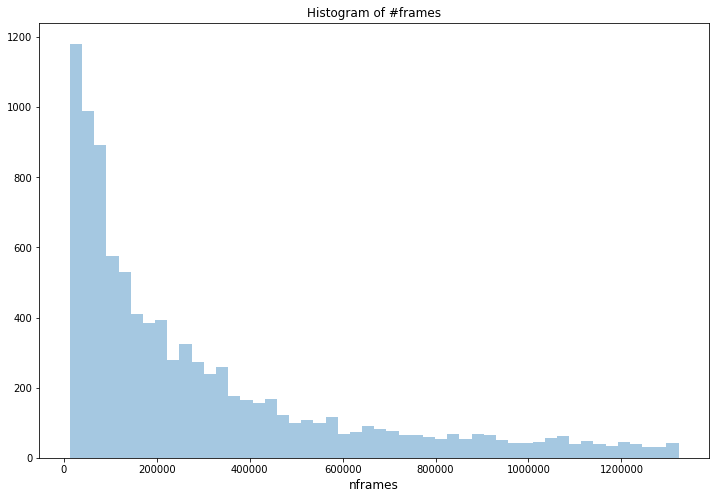

In [213]:
plt.figure(figsize=(12,8))
sns.distplot(train_data.nframes.values, bins=50, kde=False)
plt.xlabel('nframes', fontsize=12)
plt.title("Histogram of #frames")
plt.show()

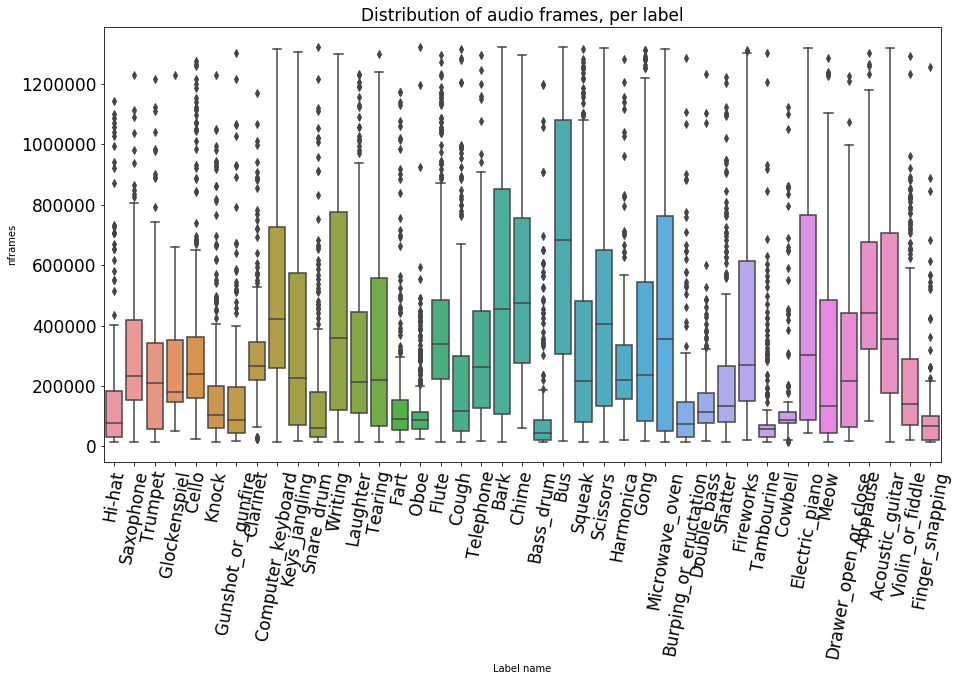

In [214]:
plt.figure(figsize=(15,8))
boxplot = sns.boxplot(x="target", y="nframes", data=train_data)
boxplot.set(xlabel='', ylabel='')
plt.title('Distribution of audio frames, per label', fontsize=17)
plt.xticks(rotation=80, fontsize=17)
plt.yticks(fontsize=17)
plt.xlabel('Label name')
plt.ylabel('nframes')
plt.show()

Total number of labels in training data :  41
Labels are :  ['Hi-hat' 'Saxophone' 'Trumpet' 'Glockenspiel' 'Cello' 'Knock'
 'Gunshot_or_gunfire' 'Clarinet' 'Computer_keyboard' 'Keys_jangling'
 'Snare_drum' 'Writing' 'Laughter' 'Tearing' 'Fart' 'Oboe' 'Flute' 'Cough'
 'Telephone' 'Bark' 'Chime' 'Bass_drum' 'Bus' 'Squeak' 'Scissors'
 'Harmonica' 'Gong' 'Microwave_oven' 'Burping_or_eructation' 'Double_bass'
 'Shatter' 'Fireworks' 'Tambourine' 'Cowbell' 'Electric_piano' 'Meow'
 'Drawer_open_or_close' 'Applause' 'Acoustic_guitar' 'Violin_or_fiddle'
 'Finger_snapping']


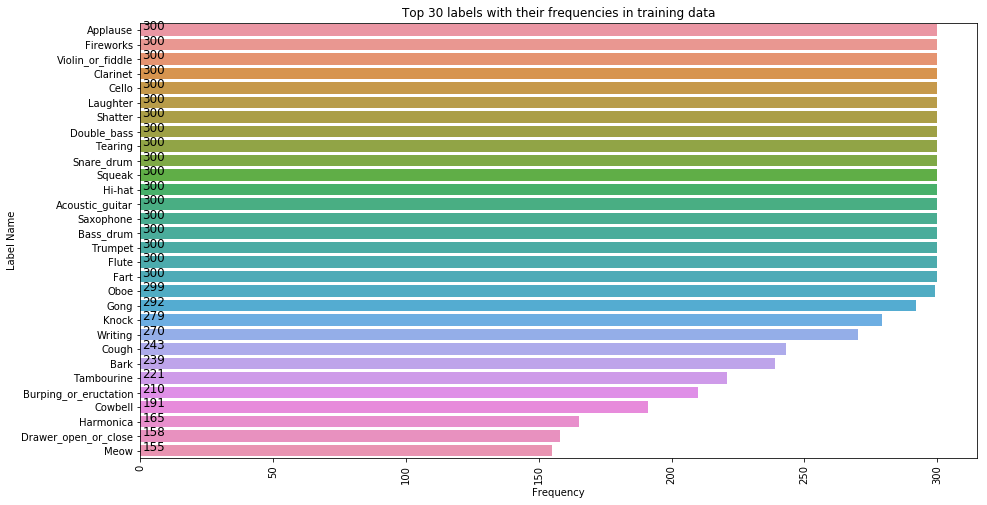

In [20]:
print("Total number of labels in training data : ",len(train_data['target'].value_counts()))
print("Labels are : ", train_data['target'].unique())
plt.figure(figsize=(15,8))
audio_type = train_data['target'].value_counts().head(30)
sns.barplot(audio_type.values, audio_type.index)
for i, v in enumerate(audio_type.values):
    plt.text(0.8,i,v,color='k',fontsize=12)
plt.xticks(rotation='vertical')
plt.xlabel('Frequency')
plt.ylabel('Label Name')
plt.title("Top 30 labels with their frequencies in training data")
plt.show()

In [21]:
temp = train_data.sort_values(by='target')
temp.head()

,file_name,target,time_series,nframes
1828,3289db4d.wav,Acoustic_guitar,"[121, 119, 117, 116, 114, 111, 107, 103, 99, 9...",1275372
5240,8dfd2855.wav,Acoustic_guitar,"[1, -2, -3, -2, -1, 1, 0, 0, -1, -1, -1, 0, 0,...",707364
3254,578874df.wav,Acoustic_guitar,"[45, 66, 71, 69, 64, 72, 80, 88, 88, 85, 85, 8...",1170414
2473,43a920c9.wav,Acoustic_guitar,"[78, 81, 85, 83, 80, 79, 71, 67, 68, 65, 64, 6...",934038
303,08a68ba1.wav,Acoustic_guitar,"[9, 29, 30, -25, -68, -66, -63, -94, -94, -71,...",16758


Acoustic_guitar : 


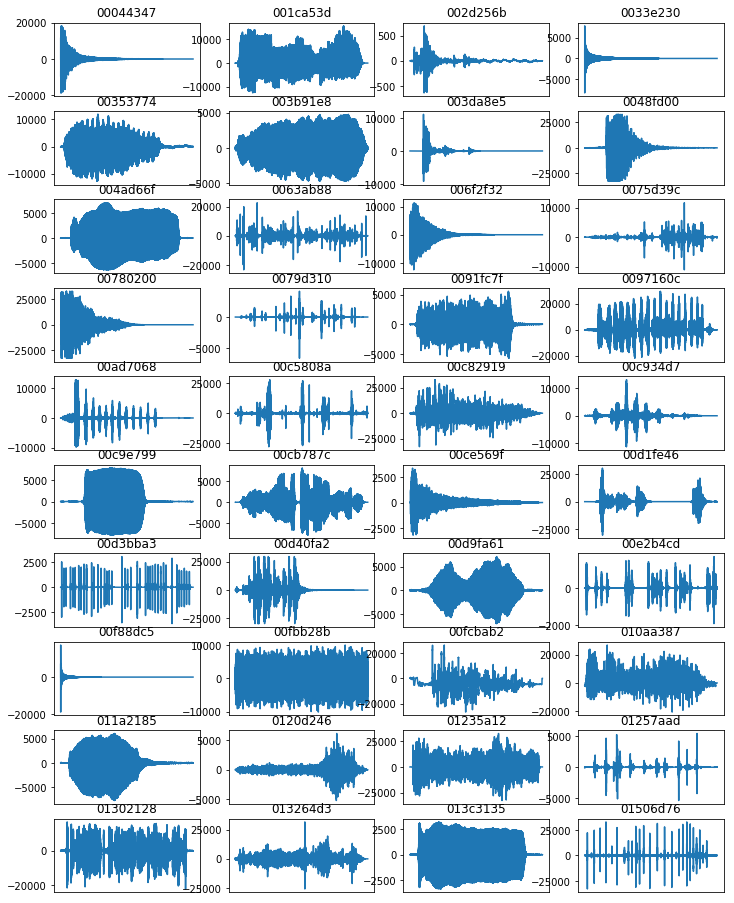

In [22]:
print("Acoustic_guitar : ")
fig, ax = plt.subplots(10, 4, figsize = (12, 16))
for i in range(40):
    ax[i//4, i%4].plot(temp['time_series'][i])
    ax[i//4, i%4].set_title(temp['file_name'][i][:-4])
    ax[i//4, i%4].get_xaxis().set_ticks([])
fig.savefig("AudioWaveform", dpi=900)     

Applause : 


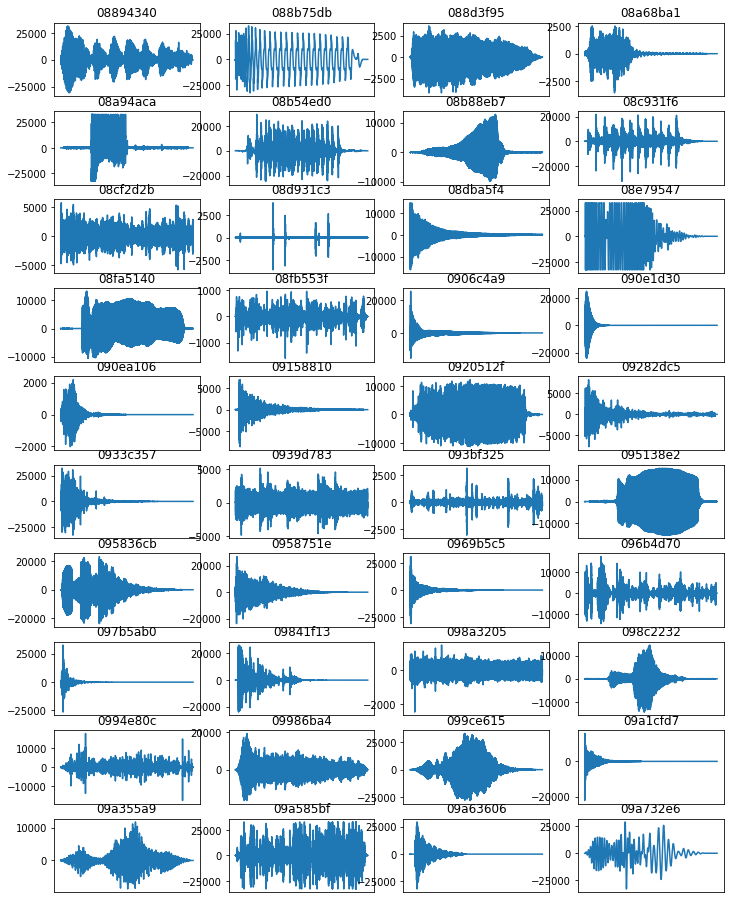

In [23]:
print("Applause : ")
fig, ax = plt.subplots(10, 4, figsize = (12, 16))
for i in range(40):
    ax[i//4, i%4].plot(temp['time_series'][i+300])
    ax[i//4, i%4].set_title(temp['file_name'][i+300][:-4])
    ax[i//4, i%4].get_xaxis().set_ticks([])

Bark : 


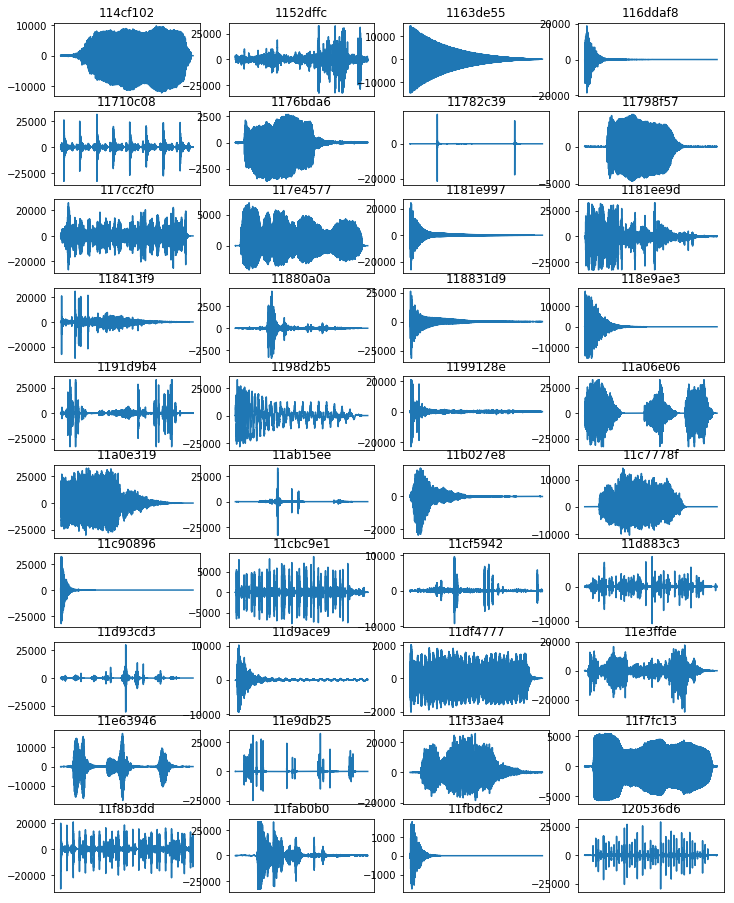

In [24]:
print("Bark : ")
fig, ax = plt.subplots(10, 4, figsize = (12, 16))
for i in range(40):
    ax[i//4, i%4].plot(temp['time_series'][i+600])
    ax[i//4, i%4].set_title(temp['file_name'][i+600][:-4])
    ax[i//4, i%4].get_xaxis().set_ticks([])

In [25]:
from wordcloud import WordCloud
wordcloud = WordCloud(max_font_size=50, width=600, height=300).generate(' '.join(train_data.target))
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.title("Wordcloud for Labels", fontsize=35)
plt.axis("off")
plt.show() 

ImportError: DLL load failed: The specified module could not be found.

In [26]:
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

In [27]:
train_audio_path = './audio_train/'
filename = '/001ca53d.wav' # Hi-hat
sample_rate, samples = wavfile.read(str(train_audio_path) + filename)

Text(0.5,0,'Seconds')

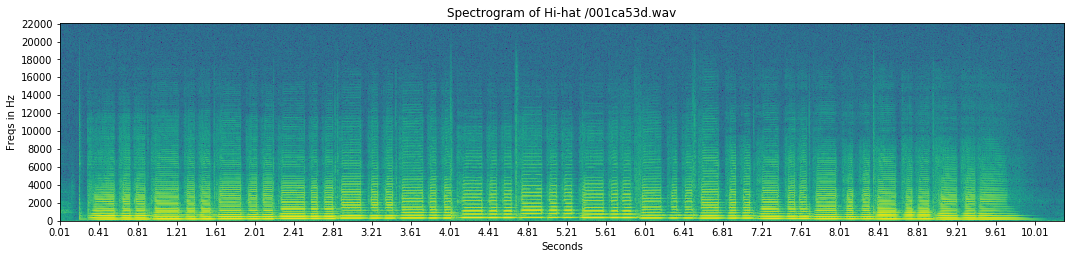

In [28]:
freqs, times, spectrogram = log_specgram(samples, sample_rate)

fig = plt.figure(figsize=(18, 8))
ax2 = fig.add_subplot(211)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::40])
ax2.set_xticks(times[::40])
ax2.set_title('Spectrogram of Hi-hat ' + filename)
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

In [29]:
mean = np.mean(spectrogram, axis=0)
std = np.std(spectrogram, axis=0)
spectrogram = (spectrogram - mean) / std

In [30]:
data = [go.Surface(z=spectrogram.T)]
layout = go.Layout(
    title='Specgtrogram of "Hi-Hat" in 3d',
    scene = dict(
    yaxis = dict(title='Frequencies', range=freqs),
    xaxis = dict(title='Time', range=times),
    zaxis = dict(title='Log amplitude'),
    ),
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [31]:
SAMPLE_RATE = 44100

def clean_filename(fname, string):   
    file_name = fname.split('/')[1]
    if file_name[:2] == '__':        
        file_name = string + file_name
    return file_name

# Generate mfcc features with mean and standard deviation
def get_mfcc(name, path):
    data, _ = librosa.core.load(path + name, sr = SAMPLE_RATE)
    assert _ == SAMPLE_RATE
    try:
        print(name)
        ft1 = librosa.feature.mfcc(data, sr = SAMPLE_RATE, n_mfcc=30)
        ft2 = librosa.feature.zero_crossing_rate(data)[0]
        ft3 = librosa.feature.spectral_rolloff(data)[0]
        ft4 = librosa.feature.spectral_centroid(data)[0]
        ft5 = librosa.feature.spectral_contrast(data)[0]
        ft6 = librosa.feature.spectral_bandwidth(data)[0]
        ft1_trunc = np.hstack((np.mean(ft1, axis=1), np.std(ft1, axis=1), skew(ft1, axis = 1), np.max(ft1, axis = 1), np.median(ft1, axis = 1), np.min(ft1, axis = 1)))
        ft2_trunc = np.hstack((np.mean(ft2), np.std(ft2), skew(ft2), np.max(ft2), np.median(ft2), np.min(ft2)))
        ft3_trunc = np.hstack((np.mean(ft3), np.std(ft3), skew(ft3), np.max(ft3), np.median(ft3), np.min(ft3)))
        ft4_trunc = np.hstack((np.mean(ft4), np.std(ft4), skew(ft4), np.max(ft4), np.median(ft4), np.min(ft4)))
        ft5_trunc = np.hstack((np.mean(ft5), np.std(ft5), skew(ft5), np.max(ft5), np.median(ft5), np.min(ft5)))
        ft6_trunc = np.hstack((np.mean(ft6), np.std(ft6), skew(ft6), np.max(ft6), np.median(ft6), np.max(ft6)))
        return pd.Series(np.hstack((ft1_trunc, ft2_trunc, ft3_trunc, ft4_trunc, ft5_trunc, ft6_trunc)))
    except:
        print('bad file')
        return pd.Series([0]*210)

In [32]:
def convert_to_labels(preds, i2c, k=3):
    ans = []
    ids = []
    for p in preds:
        idx = np.argsort(p)[::-1]
        ids.append([i for i in idx[:k]])
        ans.append(' '.join([i2c[i] for i in idx[:k]]))

    return ans, ids

In [94]:
data1=get_mfcc(train['fname'][0],'./audio_train/')
data1.shape

00044347.wav


(210,)

In [33]:
# Prepare data

train_data = pd.DataFrame()
train_data['fname'] = train['fname']
test_data = pd.DataFrame()
test_data['fname'] = audio_test_files

train_data = train_data['fname'].apply(get_mfcc, path='./audio_train/')
print('done loading train mfcc')

00044347.wav
001ca53d.wav
002d256b.wav
0033e230.wav
00353774.wav
003b91e8.wav
003da8e5.wav
0048fd00.wav
004ad66f.wav
0063ab88.wav
006f2f32.wav
0075d39c.wav
00780200.wav
0079d310.wav
0091fc7f.wav
0097160c.wav
00ad7068.wav
00c5808a.wav
00c82919.wav
00c934d7.wav
00c9e799.wav
00cb787c.wav
00ce569f.wav
00d1fe46.wav
00d3bba3.wav
00d40fa2.wav
00d9fa61.wav
00e2b4cd.wav
00f88dc5.wav
00fbb28b.wav
00fcbab2.wav
010aa387.wav
011a2185.wav
0120d246.wav
01235a12.wav
01257aad.wav
01302128.wav
013264d3.wav
013c3135.wav
01506d76.wav
015cf474.wav
0160d55e.wav
01638f61.wav
0172a2a5.wav
017ea24e.wav
01811e48.wav
0184c390.wav
018863f5.wav
018a10bb.wav
018b1df6.wav
018d1dc4.wav
0193042e.wav
01974c7c.wav
019aae9d.wav
019d2a2c.wav
01a36643.wav
01a39e95.wav
01a59a61.wav
01a59c11.wav
01a5dc85.wav
01b9f44a.wav
01c2f88b.wav
01d2475c.wav
01d4dafd.wav
01df7ada.wav
01e723f5.wav
01ec7a01.wav
01ee18fd.wav
01f2e70b.wav
01fc4661.wav
020eb9f6.wav
021f8009.wav
022092bc.wav
02267a1a.wav
02274ee8.wav
022a3507.wav
022cc908.wav

11df4777.wav
11e3ffde.wav
11e63946.wav
11e9db25.wav
11f33ae4.wav
11f7fc13.wav
11f8b3dd.wav
11fab0b0.wav
11fbd6c2.wav
120536d6.wav
1207a675.wav
12091a74.wav
120e0846.wav
121110b1.wav
12169b86.wav
121749b9.wav
12198b88.wav
121d766e.wav
1220471f.wav
122b0e88.wav
12323e04.wav
12371b67.wav
1238c3a4.wav
123d0d60.wav
124360b8.wav
124eadc9.wav
125194b0.wav
125e64b7.wav
125e6ccf.wav
1264b8c7.wav
129439fd.wav
129dc328.wav
12a38093.wav
12a650a4.wav
12cb4097.wav
12d3cdd8.wav
12d43904.wav
12d4ec7c.wav
12e4c120.wav
12f72b79.wav
12fcf7a7.wav
1301b8e3.wav
13043bab.wav
1304d545.wav
1314cdad.wav
131b1516.wav
1329c048.wav
13314233.wav
134df575.wav
1356f987.wav
1365348d.wav
1373fdab.wav
1374fcda.wav
13798190.wav
13847ff3.wav
1387ba89.wav
13903b82.wav
1391883f.wav
1393c9e0.wav
1397ddc8.wav
139c42cb.wav
13ac472f.wav
13b2325b.wav
13ca1116.wav
13da16ae.wav
13db0700.wav
13e15a49.wav
13ee6c44.wav
13f08982.wav
140027c6.wav
1401c7ff.wav
14041f9a.wav
141291fc.wav
1415b8b9.wav
14225f23.wav
142cb2c4.wav
142dac40.wav

22bea889.wav
22c7f2c0.wav
22cafa2d.wav
22cc1654.wav
22cf5ded.wav
22d8346b.wav
22e1c02c.wav
22e814ee.wav
22e83dcb.wav
22f85886.wav
231b7c90.wav
23219d68.wav
23226fdd.wav
232cc8b2.wav
2336285e.wav
233fc9e5.wav
234a0656.wav
234f4672.wav
234f95ec.wav
23663788.wav
236648d4.wav
236b8093.wav
236cbab1.wav
23704fa9.wav
2371f627.wav
2372eeb4.wav
23786ab2.wav
237b9e2a.wav
237e1078.wav
2383be9f.wav
238b16a5.wav
238fb6b8.wav
23912d0e.wav
23925f36.wav
2392ad36.wav
2398cede.wav
23a1a82e.wav
23a3984c.wav
23b6d45c.wav
23b7d8f5.wav
23b8788a.wav
23bc06b9.wav
23c0de2c.wav
23c11bee.wav
23cb1f38.wav
23cdff07.wav
23e8ac90.wav
23ebf391.wav
23f38a7e.wav
23fb24e8.wav
240590c8.wav
2405de39.wav
24202032.wav
242113be.wav
24218e25.wav
2424ad60.wav
2439dedd.wav
244025d2.wav
24503135.wav
245a503a.wav
245e58ea.wav
2462c802.wav
246ad992.wav
246e8414.wav
24779e2d.wav
24791b50.wav
247ac56f.wav
2492a915.wav
249912b5.wav
2499fad5.wav
24a3c430.wav
24addbbc.wav
24b90fac.wav
24ba0ef2.wav
24bae325.wav
24cb1e29.wav
24dfdfa5.wav

34783839.wav
34816bee.wav
348440ac.wav
3486d1db.wav
34881c5f.wav
349ff282.wav
34a1086e.wav
34a90030.wav
34b2a4f7.wav
34b432be.wav
34bb94e8.wav
34c01286.wav
34c5db34.wav
34d0a285.wav
34d3e8bc.wav
34dacafb.wav
34dd9426.wav
34e04b95.wav
34e4d187.wav
34f10443.wav
35039ae1.wav
3505e582.wav
3518605b.wav
351d0b53.wav
35270d67.wav
35271da5.wav
352875e7.wav
353b359f.wav
354bd271.wav
354c7009.wav
354cabb9.wav
35571af7.wav
3564bae2.wav
35669b76.wav
356f6f26.wav
35717b0f.wav
35721b6a.wav
357a5b9a.wav
357f7e95.wav
358139e5.wav
35839982.wav
35844050.wav
3586bc2d.wav
3592e056.wav
35950597.wav
35a38d01.wav
35accc11.wav
35ad5cd8.wav
35bd35da.wav
35d75ab7.wav
35d7ac24.wav
35e0b4ea.wav
35e97db3.wav
35f05c5d.wav
35f0e452.wav
35f2639c.wav
35f589b8.wav
35f6b357.wav
35fb9b2e.wav
35fd6638.wav
3600d08e.wav
360174e1.wav
3601d225.wav
361230e1.wav
36177faa.wav
3618cb03.wav
3623e99e.wav
3626eabd.wav
36315bea.wav
36342286.wav
363c41b3.wav
3640c702.wav
3649d60c.wav
3650faee.wav
36514399.wav
365bee4a.wav
365d9809.wav

4509d8c8.wav
450b7adb.wav
450cd355.wav
45175cc0.wav
4517a4af.wav
45243c3d.wav
45250e90.wav
4526e386.wav
452a9812.wav
4541aa66.wav
45449f84.wav
4546e002.wav
4549ffaf.wav
4551f231.wav
455377bf.wav
45539540.wav
45539bb8.wav
455aee34.wav
45665f2e.wav
456cc727.wav
458b1992.wav
458ea6cc.wav
4590ba37.wav
45910ae0.wav
45a8823e.wav
45a8d396.wav
45b9bc91.wav
45bf81f1.wav
45c077da.wav
45ce1b24.wav
45d405ca.wav
45d71502.wav
45da8553.wav
45de3233.wav
45e241c1.wav
45e5a952.wav
45e63fdd.wav
45e6e129.wav
45ea531e.wav
45f3e225.wav
4601c0f2.wav
46076458.wav
460d7b62.wav
461558c3.wav
4619c0dd.wav
461c6cd1.wav
4629e77b.wav
462b676f.wav
4636fd73.wav
464c651e.wav
465cf6eb.wav
46657625.wav
46670055.wav
466a45d5.wav
46732e56.wav
46768bc1.wav
46772c0d.wav
467953c6.wav
46798d97.wav
467ad774.wav
467c86b7.wav
468226fa.wav
468f9c4c.wav
469e4ebe.wav
46a95319.wav
46b52f97.wav
46b66e03.wav
46c0a7cd.wav
46d3877b.wav
46d7d98d.wav
46e13bac.wav
46fbedcf.wav
470e36b8.wav
470f4da3.wav
4713dac4.wav
4715ec32.wav
4715f79a.wav

54c69259.wav
54cfff7e.wav
54db602f.wav
54e0f1a8.wav
54efbdf9.wav
54f4ed65.wav
54f86efe.wav
54f89ec3.wav
54feec8f.wav
5503dbff.wav
5503e01b.wav
55040d8b.wav
5506629f.wav
55087d4d.wav
550cae67.wav
5531a5e1.wav
553245ef.wav
5543631a.wav
5554d95d.wav
5558f338.wav
5560b9c0.wav
557040c2.wav
557475a3.wav
55783841.wav
55822aae.wav
558a13e0.wav
55a17a88.wav
55a23759.wav
55aed1da.wav
55b2828b.wav
55b7b452.wav
55b7d572.wav
55c288a5.wav
55cb6a50.wav
55d52a69.wav
55d60bf0.wav
55dd4e7c.wav
55df0089.wav
5604d72a.wav
560506a1.wav
560977ac.wav
561d33d3.wav
56220972.wav
56238daa.wav
56239e18.wav
56271e97.wav
562d93f5.wav
562fed68.wav
5631d60b.wav
5638382e.wav
563f830b.wav
5644beb8.wav
564c018d.wav
564ebce0.wav
564f1a49.wav
5655bcc9.wav
565d4f5a.wav
565f3ee2.wav
5666db3a.wav
5668c2ab.wav
566f0926.wav
567ac6d1.wav
5683f1b4.wav
5689818f.wav
568f4336.wav
569ee690.wav
56a26f01.wav
56a59a85.wav
56aacb80.wav
56b18d22.wav
56bfa515.wav
56c1363d.wav
56c736b2.wav
56db9231.wav
56de1a6e.wav
56e0b337.wav
56e79c6f.wav

65de6350.wav
65f0a1fa.wav
65f60c42.wav
6604ef02.wav
660a83c4.wav
66127f3f.wav
6625eab7.wav
663954f8.wav
6639d6c6.wav
6649f294.wav
664e211b.wav
6657fa9a.wav
6658b3bb.wav
6664d3eb.wav
66764deb.wav
667c75cf.wav
667cc6dc.wav
667e0fb2.wav
66800b2b.wav
66824303.wav
668721df.wav
66895845.wav
669b7c46.wav
66a159d5.wav
66a5004c.wav
66a5b9fb.wav
66af2f72.wav
66b3d587.wav
66b65fff.wav
66b8f88f.wav
66bb1172.wav
66bcf27e.wav
66be15fd.wav
66bf4fa3.wav
66c39830.wav
66ccbc5f.wav
66dd3d3b.wav
66e0dd75.wav
66f8e692.wav
66fe50dc.wav
670093d9.wav
67013df6.wav
67052549.wav
67066eb2.wav
670a1d0b.wav
670b77c7.wav
670ef10d.wav
67186290.wav
673a623f.wav
673defaf.wav
674664a6.wav
674b6f0f.wav
674fed1f.wav
675e616f.wav
6760fd6d.wav
67822329.wav
67841fc1.wav
67909683.wav
67c69330.wav
67d86f23.wav
67e4e043.wav
67e80e0a.wav
67eceec7.wav
67ed3008.wav
67f5ced8.wav
67ffdc45.wav
68178f77.wav
681b996f.wav
6821edb0.wav
6823ee92.wav
6828f1a3.wav
682cd1a9.wav
6835397c.wav
684e4a9e.wav
68532fcb.wav
6855cd97.wav
685676c5.wav

777f8556.wav
779b0487.wav
77ab589f.wav
77b4d585.wav
77bf7b4f.wav
77d262ba.wav
77d93f2b.wav
77e64c77.wav
7804530e.wav
78182721.wav
781adc75.wav
781df1a2.wav
781e81a8.wav
781e92e0.wav
781edf6a.wav
78207d14.wav
78257899.wav
783bfebc.wav
783cbd12.wav
7844453d.wav
784920ab.wav
7859a49a.wav
785eaf77.wav
7862a91b.wav
78697428.wav
786b9250.wav
786e02d0.wav
786ee883.wav
786f6efe.wav
78760976.wav
787b0933.wav
787cf41f.wav
788d34f0.wav
788f5993.wav
789ceb04.wav
78a86075.wav
78b8ab2e.wav
78cdcdef.wav
78cf7be3.wav
78e952a2.wav
78ea9935.wav
78f0c61d.wav
78f34b3a.wav
78f43145.wav
78f90b0f.wav
78fa599e.wav
790b0c13.wav
791648dc.wav
792e752d.wav
79340af7.wav
7936731d.wav
7938de7e.wav
7941de54.wav
7941ec33.wav
794a9e40.wav
794b500a.wav
794e4a17.wav
795e7c4d.wav
79613f7e.wav
796c25a1.wav
796e727c.wav
79753d0c.wav
7975c296.wav
798b33e8.wav
798d03b7.wav
798d6d5e.wav
799055b8.wav
7996c815.wav
79a0d2c4.wav
79a50c1d.wav
79a8dbcc.wav
79b29f52.wav
79b31a2e.wav
79b83450.wav
79bb1b55.wav
79bc77b2.wav
79be82bb.wav

8855b468.wav
8861d942.wav
8863113b.wav
8865cc0e.wav
886f3b89.wav
887435e1.wav
88780eac.wav
88811cbe.wav
888cff5e.wav
88928a07.wav
889a0bc2.wav
889edf2f.wav
88ac1360.wav
88c42e27.wav
88cb5fa7.wav
88dbcd44.wav
88e24910.wav
88e792b8.wav
88e99f1c.wav
88f4eb4d.wav
88fd411f.wav
89055011.wav
8916ffcd.wav
892505e9.wav
89269203.wav
8928d1c6.wav
892a2db5.wav
893427c3.wav
893af25d.wav
89462d3b.wav
894fd536.wav
89515baf.wav
8952eee3.wav
896797e3.wav
897eed84.wav
897fc1c4.wav
8986cced.wav
8987511f.wav
898a757e.wav
899e2e78.wav
899eb17b.wav
89a058e2.wav
89a645fe.wav
89adfd2e.wav
89affc19.wav
89b17560.wav
89c2111f.wav
89c5c01b.wav
89d12569.wav
89d16dbb.wav
89d4119c.wav
89da251b.wav
89e2578a.wav
89e543b0.wav
89f13bb9.wav
89f33989.wav
89f8b625.wav
8a05af88.wav
8a11b736.wav
8a13412a.wav
8a2f4e19.wav
8a364f26.wav
8a3e5147.wav
8a45aa41.wav
8a4d0d1e.wav
8a4fce15.wav
8a635ff8.wav
8a68f631.wav
8a6ad56f.wav
8a6c6627.wav
8a739529.wav
8a843f42.wav
8a853191.wav
8a8a9e60.wav
8a9c77de.wav
8aaada9f.wav
8aab3694.wav

9a72bb2e.wav
9a76ee63.wav
9a7dd5c0.wav
9a84e7d5.wav
9a87841a.wav
9a8d697e.wav
9a9edc17.wav
9aa2b1e0.wav
9ab4b484.wav
9ab8ad15.wav
9ad0b702.wav
9ad76285.wav
9adeec85.wav
9adffd44.wav
9ae5bbd7.wav
9aeb5b7c.wav
9b1c956a.wav
9b1ede13.wav
9b2be3af.wav
9b2c9768.wav
9b35a012.wav
9b383f73.wav
9b3cfa23.wav
9b3d6d2f.wav
9b3d83ed.wav
9b3dfe43.wav
9b3ec9e8.wav
9b3f965b.wav
9b51a5b5.wav
9b529b99.wav
9b5e1c20.wav
9b651a88.wav
9b68cb7e.wav
9b78ff5c.wav
9b7ef58b.wav
9b9365b9.wav
9bc87f37.wav
9bccae2b.wav
9bcdba3b.wav
9bceebbb.wav
9bd2ef2e.wav
9bd4a0f0.wav
9bede6c7.wav
9bedf2cf.wav
9beefea5.wav
9bf2f8d2.wav
9bf40e11.wav
9c0838c1.wav
9c0a8ebb.wav
9c0b64c2.wav
9c0cf859.wav
9c13c0f4.wav
9c25e6c0.wav
9c27892f.wav
9c2ba819.wav
9c33b001.wav
9c3579f4.wav
9c452692.wav
9c4a2e2c.wav
9c5309e1.wav
9c53c34c.wav
9c54eea1.wav
9c56788f.wav
9c673f64.wav
9c87b2a0.wav
9c917ad7.wav
9c91c331.wav
9c93f3f0.wav
9ca0bd7a.wav
9ca2691f.wav
9ca86e5e.wav
9cb64934.wav
9cb7a081.wav
9cc14c5f.wav
9cc1cf39.wav
9cc4b0d0.wav
9cd05a2b.wav

ac747df0.wav
ac96314d.wav
ac98ea2b.wav
aca18275.wav
aca31840.wav
aca975c3.wav
acace1fa.wav
acae415b.wav
acb3d5da.wav
acb79f9c.wav
acb7b9d5.wav
acbde6b7.wav
acc31ab9.wav
acc419e6.wav
acc53ade.wav
accdd468.wav
accdf31f.wav
acd4f800.wav
acdb405a.wav
acde93b5.wav
ace4f283.wav
ace77c96.wav
ace78db8.wav
ace9f152.wav
acf11a33.wav
acf98333.wav
ad0436f7.wav
ad06c90b.wav
ad0c3285.wav
ad150a69.wav
ad24a452.wav
ad2bb540.wav
ad3ff995.wav
ad4200e4.wav
ad42e493.wav
ad4e15d3.wav
ad5dc3ef.wav
ad62406c.wav
ad73fca1.wav
ad7a0dd8.wav
ad7ec8cb.wav
ad91fee3.wav
ad999a17.wav
ad9a5db4.wav
ad9c9701.wav
ada49513.wav
adaada0f.wav
adabf1b8.wav
adbf981b.wav
adc9d9d8.wav
addaadf5.wav
adeff5f1.wav
adf35797.wav
adf374f7.wav
adfb7e0b.wav
ae046a29.wav
ae0820a8.wav
ae0d9801.wav
ae0ed31b.wav
ae12f941.wav
ae1d4a4b.wav
ae247229.wav
ae26f1af.wav
ae38fd74.wav
ae578781.wav
ae57e1ec.wav
ae58d0bb.wav
ae5b8b4b.wav
ae5c5c48.wav
ae5cabf7.wav
ae5fc8a0.wav
ae601b3b.wav
ae67b6b6.wav
ae6dc552.wav
ae7087c7.wav
ae733935.wav
ae76357b.wav

bd20583e.wav
bd251008.wav
bd2c737e.wav
bd30f8f2.wav
bd318932.wav
bd35d734.wav
bd50b440.wav
bd5a6718.wav
bd5bcdfa.wav
bd5c56a1.wav
bd6663dc.wav
bd66a93a.wav
bd6fca6d.wav
bd7619e2.wav
bd7a095a.wav
bd8038f5.wav
bda5299c.wav
bdaa15ed.wav
bdaa2419.wav
bdc2a7ff.wav
bdc7d7b2.wav
bddb0b0a.wav
bde1a5f8.wav
bdea8ef0.wav
bdeb67d0.wav
bdefa47c.wav
be014d8c.wav
be04d78f.wav
be0a1180.wav
be157877.wav
be1689bd.wav
be1cec35.wav
be1d4aab.wav
be207d3f.wav
be21dd3d.wav
be27070e.wav
be2f3e5c.wav
be3d113e.wav
be4b329a.wav
be4f26c0.wav
be560294.wav
be690642.wav
be6c0570.wav
be6ca096.wav
be6e2335.wav
be72f72e.wav
be75288b.wav
be7844f0.wav
be7b24cf.wav
be7cd899.wav
be7d8de5.wav
be7e8a65.wav
be885308.wav
be8920cb.wav
be8a4182.wav
be8bf725.wav
be93378b.wav
be93e48b.wav
be973667.wav
be990588.wav
bea51ca5.wav
bea68b34.wav
beb08c40.wav
beb0de1c.wav
beb6c84a.wav
bec7ea21.wav
bece203c.wav
bed02fc2.wav
bed04b14.wav
beddbf08.wav
bedf02c7.wav
bee83d50.wav
beeb29b2.wav
befa1789.wav
befdc449.wav
bf025873.wav
bf075487.wav

cd40c96c.wav
cd4aad88.wav
cd4ddf0e.wav
cd4f2689.wav
cd4f2d6f.wav
cd5379cd.wav
cd5562d2.wav
cd58468c.wav
cd7f12cc.wav
cd939e21.wav
cd9444a0.wav
cda1ce11.wav
cda43248.wav
cdac81e4.wav
cdb6724a.wav
cdb6a7a9.wav
cdb982ca.wav
cdbc82ee.wav
cdc5fe8e.wav
cdc8f61d.wav
cdcad29e.wav
cdccd612.wav
cdd1b4bd.wav
cde37f38.wav
cdeb29af.wav
cdee690e.wav
cdeece57.wav
cdf3a2c4.wav
cdf7e2d6.wav
cdfc084a.wav
cdfc8967.wav
ce03e0d8.wav
ce206b9d.wav
ce21d830.wav
ce285598.wav
ce3453bc.wav
ce34b933.wav
ce36b5f8.wav
ce3f3400.wav
ce4ba0f9.wav
ce55ed9f.wav
ce5cedda.wav
ce6149c2.wav
ce65d6b5.wav
ce75b5ce.wav
ce7ade77.wav
ce7c819c.wav
ce7cd11a.wav
ce85f672.wav
ce8d1378.wav
ce8df8e7.wav
ce8e65ee.wav
ce982cbf.wav
ce9b1907.wav
cea12d19.wav
ceac5ae1.wav
ceaea4cc.wav
ceb8e323.wav
ceba3f99.wav
cec00eea.wav
cec21578.wav
cec93123.wav
ceca4273.wav
cee316e2.wav
ceebbf33.wav
cef7f23d.wav
cf048634.wav
cf09ca4f.wav
cf20556b.wav
cf2343c6.wav
cf242525.wav
cf2877fe.wav
cf3a73a6.wav
cf469143.wav
cf5073f3.wav
cf52251c.wav
cf59ffba.wav

ddd78964.wav
ddd7971c.wav
dde05348.wav
dde416c6.wav
dde4bb79.wav
dde94d31.wav
ddf23920.wav
ddf51005.wav
de0131f0.wav
de06cab6.wav
de0debf5.wav
de2114d5.wav
de218c28.wav
de270492.wav
de2b5cdb.wav
de2b8ade.wav
de2e28fe.wav
de2fe184.wav
de361d49.wav
de3664fb.wav
de487b53.wav
de4a8fc0.wav
de4cbf74.wav
de5248bc.wav
de5bad53.wav
de6ee89b.wav
de6ee8f7.wav
de7758c6.wav
de77f91e.wav
de7c3c9d.wav
de7d1f2a.wav
de8252e6.wav
de86df69.wav
de8b4c06.wav
de8de828.wav
de8f65a2.wav
de9024fc.wav
de941b74.wav
de99b2d9.wav
de9a384f.wav
dea24938.wav
deb2681b.wav
deb87700.wav
dec1d656.wav
dec805ea.wav
dec9284d.wav
decca6ad.wav
dee0d5ac.wav
dee5f3ac.wav
deeacc1c.wav
deeba4a3.wav
deed8070.wav
defcfbdc.wav
df003f06.wav
df0573f3.wav
df0bd83e.wav
df0de169.wav
df1bc322.wav
df1d37f9.wav
df1d8082.wav
df2aac3c.wav
df39e2d0.wav
df426834.wav
df462a16.wav
df61608d.wav
df6223de.wav
df630658.wav
df66a03d.wav
df6a940f.wav
df73bad7.wav
df7593da.wav
df75d2e7.wav
df79d259.wav
df881a37.wav
df890004.wav
df8afeea.wav
df91fbcc.wav

ee3324a5.wav
ee362cd9.wav
ee46e326.wav
ee57a0d4.wav
ee601f65.wav
ee617055.wav
ee6731df.wav
ee6fa9f6.wav
ee731e7b.wav
ee7f82f8.wav
ee8776ee.wav
ee930ce6.wav
ee95e004.wav
ee972208.wav
ee99c282.wav
ee9b3800.wav
eea8f1df.wav
eeaada61.wav
eeada8ae.wav
eeb6f911.wav
eec19955.wav
eecfd7b3.wav
eed406df.wav
eee11dd7.wav
eee550a3.wav
eeeb8765.wav
eeedfb62.wav
eeeed810.wav
eef5f2f0.wav
eefee001.wav
ef04f00d.wav
ef15ef14.wav
ef2a0b91.wav
ef359f4f.wav
ef368721.wav
ef417725.wav
ef451bde.wav
ef52838f.wav
ef543e79.wav
ef57bfce.wav
ef58d42c.wav
ef5b8dd1.wav
ef5bb712.wav
ef5f80bb.wav
ef6ae93c.wav
ef73c29c.wav
ef7b753e.wav
ef7e58e3.wav
ef7ed762.wav
ef806317.wav
ef838630.wav
ef93493f.wav
ef9b2726.wav
ef9fcee9.wav
efa14040.wav
efa6c176.wav
efaa36dc.wav
efb29645.wav
efb440b7.wav
efc1953d.wav
efce5a52.wav
efd6bce5.wav
efe11ef2.wav
efe2372f.wav
efe648b4.wav
efe7e065.wav
efed0c00.wav
eff5cfd5.wav
effc853d.wav
effd020c.wav
f00fcd65.wav
f01abfa9.wav
f01d4739.wav
f023fc59.wav
f0274fc5.wav
f0363605.wav
f040db67.wav

ff95ac47.wav
ff9c6c3f.wav
ff9eae6f.wav
ffa4a506.wav
ffa61f00.wav
ffb4c87e.wav
ffbba18f.wav
ffc8d3ae.wav
ffc92b01.wav
ffcb5c56.wav
ffcefb78.wav
ffd52400.wav
ffd6b26c.wav
ffda1d2b.wav
ffdf1684.wav
ffe16cef.wav
ffe66841.wav
ffec1b59.wav
ffec59fb.wav
fff37590.wav
fff44ac6.wav
fff6a13d.wav
fff81f55.wav
done loading train mfcc


In [34]:
test_data = test_data['fname'].apply(get_mfcc, path='./audio_test/')
print('done loading test mfcc')

00063640.wav
0013a1db.wav
002bb878.wav
002d392d.wav
00326aa9.wav
0038a046.wav
003995fa.wav
005ae625.wav
007759c4.wav
008afd93.wav
00a161c0.wav
00a7a2f6.wav
00ae03f6.wav
00b2404e.wav
00beb030.wav
00c4d5b8.wav
00c92c05.wav
00ccf065.wav
00d0ab77.wav
00dffe3a.wav
00e33205.wav
00e7ed07.wav
00eac343.wav
00f2f692.wav
0102a895.wav
010a0b3a.wav
010eed01.wav
01115622.wav
01198b7e.wav
01207ce5.wav
0137bfba.wav
014eb52e.wav
01608fa3.wav
0169348e.wav
016e52da.wav
0183b482.wav
0185de6b.wav
01a5a2a3.wav
01aed32a.wav
01afccc5.wav
01b4cdb5.wav
01b85217.wav
01bb344f.wav
01bede12.wav
01c9d6d3.wav
01e628cb.wav
01e6e112.wav
01e99e2d.wav
01eccb6e.wav
01f27f99.wav
01f29edb.wav
01f9883e.wav
01fd22ba.wav
01fe4a01.wav
02107093.wav
02182ebd.wav
02198549.wav
0220d48a.wav
02210ee7.wav
022170df.wav
023431b2.wav
023e7db3.wav
023eab1f.wav
02482fdc.wav
024e45b1.wav
026820e6.wav
02697329.wav
027a8b14.wav
027dbe3e.wav
027f06cc.wav
028278f0.wav
028db587.wav
02960f07.wav
0298b2c6.wav
02a0eb3c.wav
02ad476f.wav
02af55f6.wav

11338182.wav
113b0e32.wav
113d2ca9.wav
1141793d.wav
11442d0e.wav
1146e063.wav
11544687.wav
115a258b.wav
115aa41f.wav
116b77d5.wav
11704d14.wav
11770392.wav
117dcac8.wav
11844b37.wav
11867b61.wav
1189cf83.wav
118f1763.wav
11986117.wav
119a3278.wav
11a10ce8.wav
11a4f814.wav
11ae787e.wav
11cc6d11.wav
11e6a1ec.wav
11e80486.wav
11e95378.wav
11edc852.wav
11f661bd.wav
11f6b674.wav
11fa11a0.wav
12034b1a.wav
120c7292.wav
1221a798.wav
122abe8c.wav
122f1508.wav
12394644.wav
123986b6.wav
1242ac46.wav
1248a779.wav
1248f9e2.wav
12508a7b.wav
12584f90.wav
125c89cb.wav
125dccd9.wav
12679aee.wav
126a48d2.wav
1271e7aa.wav
12770ffc.wav
12798b6a.wav
127a43ec.wav
127d3803.wav
12a0327a.wav
12a83756.wav
12ac9a66.wav
12adec75.wav
12ae3ff9.wav
12bb4b63.wav
12bf9735.wav
12bfa703.wav
12c73c11.wav
12d71e7f.wav
12d94273.wav
12e91a56.wav
12ed3971.wav
12edfe79.wav
12f5ec05.wav
12f71a9d.wav
12f9efda.wav
12fb2e35.wav
130112d1.wav
1302eade.wav
130988c6.wav
13184046.wav
13331371.wav
13354f83.wav
133599c8.wav
13371a0b.wav

2235d899.wav
223753b5.wav
223b7df6.wav
223bc959.wav
224ab14d.wav
224de930.wav
225d9633.wav
225e3135.wav
225f0626.wav
2261073e.wav
226ea2c6.wav
227f2c50.wav
228153f2.wav
22824c18.wav
22891802.wav
2293e34d.wav
22abde0a.wav
22b2efa2.wav
22b5a548.wav
22c3952c.wav
22c798ac.wav
22ca2dbb.wav
22e88b33.wav
22f3b36c.wav
22f70afe.wav
23029663.wav
23071dd2.wav
23094c55.wav
230ce5d5.wav
23176e01.wav
231d230c.wav
231e9e57.wav
231f314d.wav
232750a8.wav
232ec97b.wav
23300ded.wav
233996cf.wav
233a83b7.wav
233d0591.wav
233d8cbb.wav
235dbbf0.wav
2369256d.wav
23732830.wav
23824542.wav
23852f22.wav
238d7b37.wav
238d8cad.wav
238deaad.wav
23984d44.wav
239988bc.wav
2399acef.wav
23bae3b1.wav
23bf31da.wav
23ca551e.wav
23cdfc67.wav
23d1d920.wav
23d4cbff.wav
23e94e4f.wav
23ede927.wav
23f2b1f7.wav
23f592dd.wav
23f8b4b0.wav
23fc49d9.wav
240c45cb.wav
240d2bb2.wav
240dfb34.wav
241224d6.wav
242118f2.wav
2421d14b.wav
2423598a.wav
2429265b.wav
242ea92c.wav
2436090e.wav
243ab0b7.wav
2442e7c6.wav
244618d7.wav
244baebc.wav

347bcaa2.wav
347ebfa9.wav
3484a9b9.wav
3497cb5e.wav
349eac2f.wav
34a160da.wav
34a3bc46.wav
34a5404b.wav
34be3cb0.wav
34be5213.wav
34c7a37b.wav
34cddac7.wav
34d1fffa.wav
34d84768.wav
34f6f431.wav
34ff2f37.wav
350b89b8.wav
350ed42d.wav
35115db0.wav
351b0ba1.wav
351dcc25.wav
35235d3f.wav
352c769d.wav
352f143a.wav
3531e0f4.wav
3533dc16.wav
3538f800.wav
353b44b7.wav
353f55db.wav
3542eddc.wav
35497fc4.wav
355eeedf.wav
355f0738.wav
356cab15.wav
3579ff4b.wav
3592e0cb.wav
3597c4e5.wav
3598cc58.wav
359c9ba3.wav
35b91bb1.wav
35bb05b0.wav
35bf4ae5.wav
35c0f6b7.wav
35cb8bd1.wav
35ce58ae.wav
35d008df.wav
35d0858d.wav
35da43f9.wav
35def6dc.wav
35e1140b.wav
35e4b0fd.wav
35f3a48c.wav
35f6a4b8.wav
35ff3f29.wav
35ffae5a.wav
360348af.wav
360e9c8e.wav
360ed752.wav
361285ac.wav
3617db48.wav
361c028f.wav
361fbd17.wav
3620c12b.wav
3623b02e.wav
363a3760.wav
364d2e90.wav
36507474.wav
365a4c89.wav
365f9044.wav
3660d731.wav
3668b282.wav
36690c27.wav
3670cc04.wav
367ba81f.wav
36a0c334.wav
36a2202d.wav
36a92b29.wav

45d72a23.wav
45da6408.wav
45da8abe.wav
45e681c2.wav
45efe793.wav
45f7e58b.wav
45fbe67a.wav
45fc6c9b.wav
45fd564e.wav
46121269.wav
46186ebd.wav
46200873.wav
462a705d.wav
462c7777.wav
462ec068.wav
46321665.wav
46380229.wav
463d4298.wav
463de778.wav
463e231d.wav
4646a6e3.wav
464ae66b.wav
465c6192.wav
46622a4c.wav
466647df.wav
4666bee5.wav
466e8bab.wav
467c5a5a.wav
4683f13c.wav
4698193e.wav
4699c352.wav
46a20346.wav
46a24375.wav
46a4d46b.wav
46ab7601.wav
46aebc33.wav
46b06055.wav
46b5a369.wav
46d15a22.wav
46e1f70a.wav
46f07933.wav
46f0b51b.wav
4706cebd.wav
471a6fca.wav
471ab81d.wav
47268a0a.wav
47333aac.wav
4733f511.wav
473bd952.wav
473e9a47.wav
4741ae62.wav
47494a3a.wav
47538a81.wav
47542ddc.wav
47744c05.wav
47793988.wav
47795659.wav
47913bc5.wav
4797fc8b.wav
479ab3cf.wav
479d9994.wav
47a26734.wav
47ac630d.wav
47acbfcd.wav
47af6236.wav
47b7eb95.wav
47bba234.wav
47c48965.wav
47c57028.wav
47ca6f5b.wav
47e5c682.wav
47eba90e.wav
47ebd5f5.wav
47f5e3e1.wav
47f7b3fa.wav
47fa98ea.wav
480fb007.wav

579233c0.wav
5796277c.wav
579c7267.wav
579d6de4.wav
57a43af9.wav
57a656ec.wav
57b81803.wav
57ba1700.wav
57c1e877.wav
57c9d455.wav
57d6baac.wav
57dc8d92.wav
57e67bad.wav
57e82a43.wav
57ee6620.wav
57f200ec.wav
57f9f1e8.wav
58017079.wav
580468b6.wav
58050f57.wav
58072015.wav
580cf7d2.wav
58151c44.wav
582aaabc.wav
582bf94d.wav
582c743f.wav
583119bf.wav
5835b312.wav
583c89f0.wav
583e2d70.wav
58477ce0.wav
584821f7.wav
5851365b.wav
58577d4d.wav
585a58c9.wav
585c8c34.wav
585fbcea.wav
5864f403.wav
58663e0d.wav
5869a324.wav
586a68fb.wav
587a184f.wav
587e867e.wav
5880cfd4.wav
5882e87b.wav
58848256.wav
58864b07.wav
5895612c.wav
589de45d.wav
58a13aa9.wav
58bd136f.wav
58d73bbd.wav
58f490d2.wav
59082bc2.wav
590cef8a.wav
59173448.wav
59190ef2.wav
591d35d6.wav
591d9bdc.wav
591f738e.wav
59214b26.wav
5924a0f4.wav
592805ad.wav
59293ace.wav
592e1577.wav
592f32bb.wav
5931d373.wav
5938a674.wav
59393627.wav
59405f12.wav
5948a83b.wav
594e74ae.wav
5965d649.wav
5968f9ac.wav
59698313.wav
596cf925.wav
597a143a.wav

69166275.wav
691e2ba7.wav
69203905.wav
69270252.wav
69353c44.wav
6935ee98.wav
693994bb.wav
6953fc48.wav
695db66e.wav
69657535.wav
696b7241.wav
696cc865.wav
69764012.wav
69765685.wav
69782821.wav
697acb91.wav
6985e62e.wav
698f7dfd.wav
69901110.wav
6990941d.wav
699ea314.wav
69b3838c.wav
69ba69e3.wav
69bd1969.wav
69c0b1e9.wav
69c6b75d.wav
69ca1307.wav
69cca687.wav
69d1b79f.wav
69d8927f.wav
69eb69bf.wav
69f00142.wav
69fb974d.wav
69fcaa90.wav
6a010a3b.wav
6a1faea9.wav
6a3a9e86.wav
6a454d5f.wav
6a49870b.wav
6a4a0f6c.wav
6a4c6be2.wav
6a4cac8d.wav
6a516e3c.wav
6a52566a.wav
6a5304b5.wav
6a59da0e.wav
6a6928b4.wav
6a720a79.wav
6a770aa1.wav
6a825284.wav
6a8317a5.wav
6a8e35d8.wav
6a8e3fbf.wav
6a9260c2.wav
6a95684b.wav
6a9f8d7f.wav
6aa576a2.wav
6aa953a8.wav
6aaac9d2.wav
6aaaedea.wav
6aac4b3b.wav
6aad5e4c.wav
6aaffcf2.wav
6ab2a13b.wav
6ab6ca9b.wav
6ab784a0.wav
6ab8e56f.wav
6abe08e1.wav
6ac046a1.wav
6ac32ae8.wav
6ad4ccea.wav
6ad8d33e.wav
6add5aad.wav
6ae82a23.wav
6aef9576.wav
6aefce55.wav
6af4f3e5.wav

792b2873.wav
79346331.wav
7935b0e2.wav
793d76b2.wav
7942ef15.wav
7945d2a7.wav
79584580.wav
795e11a4.wav
7961cae0.wav
79654d40.wav
796890cc.wav
797780fa.wav
79814830.wav
79841cc8.wav
7988444e.wav
79907fe4.wav
7990842b.wav
7997b2bf.wav
799a5d18.wav
79a18311.wav
79a41b44.wav
79aa749f.wav
79ae8708.wav
79b42a4b.wav
79b90729.wav
79b9d0ac.wav
79c42635.wav
79c9f959.wav
79cf3157.wav
79db77f8.wav
79ea9c8d.wav
79f68bc0.wav
7a08f881.wav
7a135d94.wav
7a1461f6.wav
7a21d4ba.wav
7a24dfe2.wav
7a2954e4.wav
7a29799f.wav
7a384640.wav
7a39c609.wav
7a3ddfdd.wav
7a3dfe00.wav
7a493aa4.wav
7a52fb48.wav
7a596406.wav
7a5aa493.wav
7a6823fe.wav
7a720227.wav
7a73f213.wav
7a774e4f.wav
7a7d547f.wav
7a8b587a.wav
7a914c27.wav
7a929de6.wav
7a94d08a.wav
7a96fbb4.wav
7a985ef9.wav
7a991ba0.wav
7aa42206.wav
7aa58339.wav
7ab9f7af.wav
7aba998a.wav
7abe967a.wav
7ac649fa.wav
7ac71752.wav
7ad14962.wav
7af6ef7f.wav
7af73c7d.wav
7af77bfe.wav
7b188557.wav
7b1adebd.wav
7b202f31.wav
7b2d48f6.wav
7b2f865c.wav
7b3215eb.wav
7b3376cd.wav

895da9f4.wav
895edd06.wav
8961de43.wav
896e5a21.wav
896ee186.wav
897071cd.wav
897317d0.wav
89779518.wav
8977a6ca.wav
897a1c21.wav
8989a18a.wav
89971a2c.wav
8998d863.wav
899b27fc.wav
89a93553.wav
89b36fe8.wav
89b76fbd.wav
89bf91c0.wav
89db586a.wav
89e23feb.wav
89f16e34.wav
8a0f1c7b.wav
8a0f47fe.wav
8a16d7ba.wav
8a16fd63.wav
8a1795c0.wav
8a18fb2a.wav
8a23c5d3.wav
8a24496e.wav
8a25df61.wav
8a2793a4.wav
8a340933.wav
8a382bf3.wav
8a3e131b.wav
8a4865fe.wav
8a54a88f.wav
8a5535d7.wav
8a5fdff9.wav
8a65cf0f.wav
8a67db0c.wav
8a686d60.wav
8a764cbf.wav
8a772083.wav
8a775bde.wav
8a790989.wav
8a82613e.wav
8a8290ff.wav
8a82ff41.wav
8a86d731.wav
8a8f86ec.wav
8a93cd50.wav
8a94d1c5.wav
8a97db28.wav
8aa3ebc6.wav
8aa74761.wav
8aab9bdd.wav
8aba992e.wav
8ac13a9b.wav
8aca08a7.wav
8ace0a5f.wav
8ad56763.wav
8ad60086.wav
8ad6985a.wav
8ae9fe4f.wav
8af2209c.wav
8af9d4b0.wav
8affb34b.wav
8b01169f.wav
8b0dd9f6.wav
8b11746f.wav
8b14bd95.wav
8b1e87cb.wav
8b21e03d.wav
8b3869ca.wav
8b3f9d2e.wav
8b407f48.wav
8b42e5d6.wav

9a96c44a.wav
9a973039.wav
9a98500f.wav
9a9a8b04.wav
9a9d7b10.wav
9aa8d293.wav
9aaea490.wav
9abe9084.wav
9ac3ffa8.wav
9ac42fb4.wav
9ad09b7d.wav
9ad4fdbf.wav
9ad810eb.wav
9aee1a9a.wav
9af56cf1.wav
9afbb20d.wav
9b012806.wav
9b0796f8.wav
9b08c087.wav
9b0edc5d.wav
9b174107.wav
9b17a88f.wav
9b1825ea.wav
9b1d68cf.wav
9b2b21bb.wav
9b2d6829.wav
9b2dcfef.wav
9b325889.wav
9b34f24d.wav
9b3650e9.wav
9b3f9aae.wav
9b4b0e42.wav
9b4c38a0.wav
9b51add4.wav
9b5afc0b.wav
9b5fd9aa.wav
9b660e81.wav
9b6955a0.wav
9b6a33b1.wav
9b6a4d3a.wav
9b7614f5.wav
9b7dba6d.wav
9b864a90.wav
9b90b201.wav
9ba882fa.wav
9bb0e4ff.wav
9bb401a1.wav
9bb58c86.wav
9bb6e17e.wav
9bb8f8b6.wav
9bbc1586.wav
9bc11fc2.wav
9bc1b7ae.wav
9bc1cda5.wav
9bc8fef8.wav
9bc9408c.wav
9bccee27.wav
9beda058.wav
9bfac103.wav
9bff1d02.wav
9c0037b8.wav
9c063f54.wav
9c08f924.wav
9c14157b.wav
9c17a9ab.wav
9c1947db.wav
9c1b8f23.wav
9c224683.wav
9c31bbec.wav
9c3f96c0.wav
9c4462a9.wav
9c53edce.wav
9c5b37c5.wav
9c69283b.wav
9c7058f4.wav
9c7a676e.wav
9c7cee6e.wav

ab5fd952.wav
ab63bd75.wav
ab6a14cf.wav
ab6e353a.wav
ab732a2f.wav
ab76f226.wav
ab8a2c34.wav
ab932fc9.wav
ab93d9cd.wav
aba7141f.wav
aba89c25.wav
abadf3eb.wav
abb026cd.wav
abc850c5.wav
abd88f50.wav
abdcd3c9.wav
abe03624.wav
abe80677.wav
abea2ac0.wav
abed8684.wav
abf29673.wav
abf5d504.wav
ac06a685.wav
ac11a01e.wav
ac1f1df0.wav
ac22a1c0.wav
ac2664fa.wav
ac2de61d.wav
ac3b7f7f.wav
ac41f36e.wav
ac427317.wav
ac4477b8.wav
ac44f2af.wav
ac4602c8.wav
ac4d4d6b.wav
ac4e170d.wav
ac507f36.wav
ac507fd0.wav
ac590977.wav
ac71fa9c.wav
ac755dd6.wav
ac7b9e18.wav
ac7c8ae3.wav
ac7eec59.wav
ac822579.wav
ac8b9268.wav
ac8c9f4c.wav
ac8cce64.wav
ac909b62.wav
ac9151cf.wav
ac916661.wav
ac9f8827.wav
aca050ea.wav
aca46609.wav
acb2260c.wav
acb2ae9a.wav
acb33e73.wav
acb60d34.wav
acba91ee.wav
accb746f.wav
acd9adb9.wav
acdcfb8f.wav
ace88278.wav
acf4569a.wav
acf4890c.wav
ad0ab6fa.wav
ad142ed0.wav
ad1a8bce.wav
ad1f2187.wav
ad23f99c.wav
ad2ee4b2.wav
ad323692.wav
ad4c828c.wav
ad4d97de.wav
ad5821b3.wav
ad617575.wav
ad6e3b22.wav

bbdf9ae2.wav
bbe1a14c.wav
bbea2f9f.wav
bbeaccaa.wav
bbebe261.wav
bbec9d23.wav
bbf25c3e.wav
bbf97aa9.wav
bc0cd163.wav
bc0d54b5.wav
bc0f996a.wav
bc26ba19.wav
bc2cc241.wav
bc3264fd.wav
bc34f748.wav
bc39ca14.wav
bc3e887e.wav
bc3f7a51.wav
bc4f5d4a.wav
bc57d17d.wav
bc58fae1.wav
bc5bf3f9.wav
bc5d2e8c.wav
bc8708ff.wav
bc8824ff.wav
bc89b753.wav
bc89b9ec.wav
bc8a1c15.wav
bc8dcc2d.wav
bc97389e.wav
bc9c55c2.wav
bc9ecaac.wav
bca78681.wav
bcaff252.wav
bcc40a35.wav
bccd2cb3.wav
bcda4910.wav
bcf99eb3.wav
bcfe81f2.wav
bd062294.wav
bd0a9017.wav
bd0fa421.wav
bd16d29a.wav
bd1d9f10.wav
bd23c357.wav
bd271732.wav
bd3ba846.wav
bd489bec.wav
bd575d0a.wav
bd58d191.wav
bd5e02e4.wav
bd63ed5f.wav
bd661885.wav
bd6b558b.wav
bd6c1270.wav
bd702317.wav
bd70a3ae.wav
bd772d30.wav
bd789949.wav
bd79cbb8.wav
bd8a0d61.wav
bd9cf441.wav
bdb3d952.wav
bdbb5a2a.wav
bdc28adc.wav
bdc2a6f2.wav
bdc3a110.wav
bdc5b4a7.wav
bdd0b24e.wav
bdd2a664.wav
bdd2f431.wav
bdd4e518.wav
bdee019c.wav
bdf92503.wav
be09bb9d.wav
be0c6f8d.wav
be12134a.wav

cd52fd53.wav
cd554105.wav
cd559055.wav
cd58c8ce.wav
cd605279.wav
cd650af2.wav
cd68143e.wav
cd6dd770.wav
cd751727.wav
cd854043.wav
cd9072e8.wav
cd9baa07.wav
cda7d297.wav
cdaedc34.wav
cdaf7bdc.wav
cdb4ced5.wav
cdb9d835.wav
cdc39da1.wav
cdc93f9d.wav
cdd10728.wav
cdd5fb4c.wav
cdde037c.wav
cdf37f64.wav
cdf81fc0.wav
cdfe1fa9.wav
ce031a6c.wav
ce067aac.wav
ce06a3ca.wav
ce079011.wav
ce091e31.wav
ce19c5b4.wav
ce1beffb.wav
ce1d5c23.wav
ce203f06.wav
ce295bfd.wav
ce2bd6c9.wav
ce3a3b23.wav
ce3e08ea.wav
ce48ccbb.wav
ce4b2f15.wav
ce5b2140.wav
ce6859a8.wav
ce8172d5.wav
ce86e76a.wav
ce890eb4.wav
ce95dcea.wav
ce99f94c.wav
ce9c1ce8.wav
ce9dd7b8.wav
cea165f8.wav
cea67a35.wav
ceab0387.wav
ceb6e9c1.wav
cec9647b.wav
cecb67c0.wav
cecd4f9f.wav
cee05a5f.wav
cee063a7.wav
ceec151c.wav
ceef96eb.wav
cefb71c5.wav
ceffb395.wav
cf0471b4.wav
cf0d3082.wav
cf0f872c.wav
cf109573.wav
cf156f7d.wav
cf225634.wav
cf2c1168.wav
cf370066.wav
cf3933c7.wav
cf3f6594.wav
cf4eb36a.wav
cf510fc8.wav
cf583cf8.wav
cf5ec323.wav
cf654f37.wav

de949e03.wav
de9880e4.wav
deae4e95.wav
debd7ead.wav
dec2ea0c.wav
decb026a.wav
dee2e211.wav
dee96f11.wav
defb3dc5.wav
defbeee1.wav
df08654b.wav
df0ea972.wav
df11e694.wav
df1800bf.wav
df19dd97.wav
df1bb16e.wav
df43c93e.wav
df5a3843.wav
df62e13c.wav
df640665.wav
df645d4a.wav
df6e55f8.wav
df791b3d.wav
df7a5de3.wav
df8187d0.wav
df855c2d.wav
df865e55.wav
df8be1a8.wav
df91939e.wav
df988fa6.wav
dfa20dc8.wav
dfa75eb5.wav
dfb669c0.wav
dfbc9586.wav
dfbcc619.wav
dfbf13a1.wav
dfc2719c.wav
dfc65a71.wav
dfd91df3.wav
dfd95f88.wav
dfe99aff.wav
dfe9ea46.wav
dfec892c.wav
dff8a9ed.wav
dffcc729.wav
e016ff6d.wav
e0273514.wav
e0278ad9.wav
e02910e8.wav
e035f97b.wav
e03c8bf3.wav
e0419e15.wav
e043afb3.wav
e0457b4a.wav
e059d9a7.wav
e06b1539.wav
e06b693c.wav
e06bfc3d.wav
e06deab0.wav
e0802994.wav
e083ae15.wav
e08808ae.wav
e08fced0.wav
e0a72225.wav
e0ad96e1.wav
e0bfc4ec.wav
e0d34abd.wav
e0d8ea27.wav
e0d8ff62.wav
e0d96e55.wav
e0de96a6.wav
e0e373a5.wav
e0e6a1de.wav
e0eb0c8a.wav
e0ee247e.wav
e0fc67d9.wav
e103173b.wav

f0f06c4b.wav
f1034aef.wav
f1067374.wav
f109869d.wav
f10c6630.wav
f1140903.wav
f1198998.wav
f11d37bc.wav
f1297967.wav
f12b67a6.wav
f13486a1.wav
f1437485.wav
f145e956.wav
f1466adb.wav
f153a007.wav
f155cd5f.wav
f15b1a1d.wav
f16f1900.wav
f175608c.wav
f17ce543.wav
f17d7d55.wav
f17ef252.wav
f17f8e04.wav
f1823776.wav
f18790fe.wav
f18dc106.wav
f1906c3d.wav
f1909601.wav
f1a04183.wav
f1a9435c.wav
f1b0f1af.wav
f1b36ddb.wav
f1b721e0.wav
f1c27002.wav
f1cb3ebe.wav
f1cc3f7a.wav
f1dd45a6.wav
f1e0f2a8.wav
f1ea96b7.wav
f1eeddd8.wav
f202372a.wav
f21d3c2e.wav
f222ac0b.wav
f22b0be7.wav
f22e80d2.wav
f22e9699.wav
f233e49d.wav
f249ccdf.wav
f25036f6.wav
f269ff76.wav
f26a7d90.wav
f26f9711.wav
f27a6fcd.wav
f27c1378.wav
f2849aa9.wav
f290369d.wav
f29686d0.wav
f29881fc.wav
f2a1e334.wav
f2ae2b94.wav
f2b378fb.wav
f2b6fd89.wav
f2ba99d8.wav
f2be783d.wav
f2bf7e84.wav
f2c60da6.wav
f2c781bc.wav
f2ce1323.wav
f2e678fe.wav
f2f5a41a.wav
f305a054.wav
f30f5fca.wav
f32309a8.wav
f324562c.wav
f330bf67.wav
f3368ed3.wav
f33acfe4.wav

In [35]:
train_data['fname'] = train['fname']
test_data['fname'] = audio_test_files

train_data['label'] = train['label']
test_data['label'] = np.zeros((len(audio_test_files)))

In [36]:
train_data.head()

,0,1,2,3,4,5,6,7,8,9,...,202,203,204,205,206,207,208,209,fname,label
0,-446.838467,52.372300,-53.377823,-3.740264,-8.318184,-11.119042,-14.467405,-10.285843,-10.966904,-2.670278,...,15.643222,7.055138,1989.168387,775.044969,0.714498,3543.959962,1740.511713,3543.959962,00044347.wav,Hi-hat
1,-375.754678,151.572502,-41.933635,-0.165071,5.955898,-12.535086,-13.192531,-13.657687,-9.174413,-19.668802,...,34.161463,6.676251,906.662232,506.447373,3.305549,3388.692162,733.209469,3388.692162,001ca53d.wav,Saxophone
2,-658.236035,102.368917,20.626247,9.108918,-4.891736,7.259463,-1.862530,1.661778,5.499974,5.338336,...,18.050029,8.280023,2840.134501,611.530727,-0.202585,3631.676275,2698.475507,3631.676275,002d256b.wav,Trumpet
3,-770.905450,16.077204,-3.556132,-10.957762,-19.071291,-9.632298,4.279781,14.633798,19.459229,12.089039,...,20.719852,13.943471,2758.526365,772.741940,-0.909257,3553.924270,3235.174665,3553.924270,0033e230.wav,Glockenspiel
4,-343.603965,137.873119,-28.701815,8.593180,2.751699,-0.301433,-9.502459,-3.774746,13.056789,7.197487,...,23.051968,8.232091,1639.312250,657.051222,1.086833,3113.026574,1267.272974,3113.026574,00353774.wav,Cello


In [56]:

X = train_data.drop(['label', 'fname'], axis=1)
feature_names = list(X.columns)
X = X.values
labels = np.sort(np.unique(train_data.label.values))
num_class = len(labels)
c2i = {}
i2c = {}
for i, c in enumerate(labels):
    c2i[c] = i
    i2c[i] = c
y = np.array([c2i[x] for x in train_data.label.values])

In [38]:
X_test = test_data.drop(['label', 'fname'], axis=1)
X_test = X_test.values

In [39]:
print(X.shape)
print(X_test.shape)

(9473, 210)
(9400, 210)


In [40]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

In [106]:
X_scaled.shape

(9473, 210)

In [228]:
# Apply PCA for dimension reduction
pca = PCA(n_components=210).fit(X_scaled)
X_pca = pca.transform(X_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(sum(pca.explained_variance_ratio_)) 

1.0


In [229]:
X_pca.shape

(9473, 210)

In [230]:
# Fit an SVM model
X_train, X_val, y_train, y_val = train_test_split(X_pca, y, test_size = 0.2, random_state = 42, shuffle = True)

clf = SVC(kernel = 'rbf', probability=True)

clf.fit(X_train, y_train)

print(accuracy_score(clf.predict(X_val), y_val))

0.684960422164


In [235]:
# Fit an SVM model
X_train, X_val, y_train, y_val = train_test_split(X_pca, y, test_size = 0.2, random_state = 42, shuffle = True)

clf = SVC(kernel = 'rbf', probability=True)

clf.fit(X_train, y_train)

print(accuracy_score(clf.predict(X_val), y_val))

0.684960422164


In [60]:
labels_test

3593    60f9e3ed.wav
2273    3e20cc09.wav
8395    e3278076.wav
967     1aae0429.wav
8966    f244e1e2.wav
9400    fe3a87db.wav
6876    bb5154e7.wav
1346    2500d6e9.wav
6720    b755be21.wav
6576    b3d33a56.wav
7632    cf3a73a6.wav
5620    991fa1d7.wav
6329    ad150a69.wav
1297    23a3984c.wav
6207    a9be5059.wav
5884    a07014b6.wav
7378    c85c0e61.wav
315     090e1d30.wav
3689    639573a0.wav
1087    1e0d7652.wav
2517    44f9acf9.wav
8690    ead4ea8c.wav
7047    bffd6b19.wav
7658    cfdbf38b.wav
4477    7996c815.wav
5785    9dba4c86.wav
4814    81f0b550.wav
6325    acf98333.wav
794     1661aa86.wav
7890    d63ed02d.wav
            ...     
9212    f8f2585d.wav
2145    3acce964.wav
1832    32bd34b5.wav
8005    d914225a.wav
2087    3966c159.wav
3021    518250e2.wav
5361    916f2fba.wav
8643    e97d9707.wav
4936    85395673.wav
8998    f2ed2975.wav
2836    4cb7c775.wav
8203    de270492.wav
5888    a090c45a.wav
834     172d7f14.wav
8298    e08535fa.wav
6065    a5736387.wav
6309    acb79

In [231]:
# Define the paramter grid for C from 0.001 to 10, gamma from 0.001 to 10
C_grid = [0.001, 0.01, 0.1, 1, 10]
gamma_grid = [0.001, 0.01, 0.1, 1, 10]
param_grid = {'C': C_grid, 'gamma' : gamma_grid}

grid = GridSearchCV(SVC(kernel='rbf'), param_grid, cv = 3, scoring = "accuracy")
grid.fit(X_train, y_train)

# Find the best model
print(grid.best_score_)

print(grid.best_params_)

print(grid.best_estimator_)

0.669833729216
{'C': 10, 'gamma': 0.001}
SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [236]:
# Optimal model
clf = SVC(kernel = 'rbf', C = 10, gamma = 0.001, probability=True)

clf.fit(X_train, y_train)

print(accuracy_score(clf.predict(X_val), y_val))

0.702374670185


In [47]:
# Optimal model
clf = SVC(kernel = 'rbf', C = 100, gamma = 0.01, probability=True)

clf.fit(X_train, y_train)

print(accuracy_score(clf.predict(X_val), y_val))

0.715567282322


In [48]:
# Optimal model
clf = SVC(kernel = 'rbf', C = 50, gamma = 0.01, probability=True)

clf.fit(X_train, y_train)

print(accuracy_score(clf.predict(X_val), y_val))

0.715567282322


In [45]:
# Fit the entire training sets
clf.fit(X_pca, y)
str_preds, _ = convert_to_labels(clf.predict_proba(X_test_pca), i2c, k=3)

# Write to outputs
subm = pd.DataFrame()
subm['fname'] = audio_test_files
subm['label'] = str_preds
subm.to_csv('submission.csv', index=False)

In [227]:
# Fit the entire training sets
clf.fit(X_pca, y)
str_preds, _ = convert_to_labels(clf.predict_proba(X_test_pca), i2c, k=1)

# Write to outputs
subm = pd.DataFrame()
subm['fname'] = audio_test_files
subm['label'] = str_preds
subm.to_csv('submission10.csv', index=False)

In [ ]:
clf.fit(X_pca, y)

In [246]:
str_preds1, _ = convert_to_labels(clf.predict(), i2c, k=1)
print('Name',audio_test_files[0])
print('Preditcted',str_preds1)

ValueError: Expected 2D array, got 1D array instead:
array=[ -4.55775599e+00  -7.30957644e+00  -1.55116087e+00   1.85059723e+00
   1.44353512e+00  -5.14220396e-01  -1.23046360e-01  -9.26594853e-01
  -3.49525182e+00   1.04550676e+00  -1.94915512e+00  -9.67678020e-01
  -1.12926353e-01  -1.50522457e+00   9.27284280e-01   9.57486534e-01
  -8.04510738e-01   2.78387490e+00   1.57571975e+00  -1.65508181e+00
   4.05156760e-01   1.23279475e+00   4.74509806e-01  -3.78375577e-02
  -3.58702044e-02   1.36296924e+00  -1.78223924e-01   1.07424159e+00
   1.58081280e+00   2.24589256e-01   4.16272853e-01  -1.35126044e-01
  -1.12736586e+00  -2.06480254e+00   2.83940994e-01   1.15046119e+00
  -1.91844158e-01   2.05014617e+00  -1.66980246e-01  -1.16765418e+00
  -1.36365777e-01  -7.33241209e-02  -1.56078099e+00   1.51536402e+00
  -2.04820272e-01  -2.59049499e-01   1.76157632e+00   5.91707256e-01
   2.89343575e-02  -1.99395440e-01  -9.09865674e-01  -8.25781922e-01
  -6.01768423e-02   4.21480896e-01  -6.55329447e-01   3.39613749e-01
  -1.13472188e+00   7.74712645e-01  -1.03452073e-01   1.53107142e+00
   1.96166335e-01   1.18526811e+00  -9.18243339e-01  -1.10193747e-01
   7.19800848e-01  -2.84494564e-01  -1.12470650e+00   2.23292109e-01
  -8.66783807e-01   1.02393311e+00   1.52586574e+00   1.42834206e+00
  -2.85677616e-01   1.19100774e-01   9.09813506e-01   3.89335156e-01
  -6.42485683e-01  -6.30543123e-01  -8.16884395e-01  -3.83064083e-02
  -6.84267874e-01   2.00026995e-01  -6.48786874e-01   1.73872295e-02
   1.78144697e-01   1.44480728e+00   2.33568109e-01   5.27965829e-01
  -4.55716614e-02  -6.63018221e-01   4.99122337e-01   2.17007591e-01
  -1.93487174e-01  -1.82521176e-01   5.44110246e-01   3.94294985e-01
  -7.23330524e-01  -3.13486486e-01  -8.27877320e-01  -4.51723116e-01
   1.28893595e-01  -1.70490982e-01   7.05025892e-01   2.13054806e-01
  -3.47642457e-01   3.72201100e-01  -1.19190124e-01  -9.21043089e-01
   9.82193921e-02   3.36975421e-01   7.73996346e-01  -1.49084182e-01
   2.92159661e-01  -1.81862734e-01  -3.99064325e-01  -1.87621589e-01
  -1.30886919e-01  -2.60501924e-01   1.23056386e-01   2.11486831e-01
  -7.06294578e-01   1.54657168e-01  -2.66795421e-01  -3.55366709e-02
  -1.54293875e-01  -1.59163898e-01  -2.74743232e-01   1.89370408e-01
  -2.09403328e-01  -1.14213579e-01   4.19647030e-01   5.73375798e-02
   2.96004443e-01  -3.98832754e-01   2.06716815e-03   7.66951278e-02
  -2.07851801e-01  -5.82901839e-01   2.03923835e-01   7.92708502e-02
   2.71556518e-02   1.92100987e-01   1.09831996e-01   5.48240950e-02
  -1.87907365e-01   1.58173069e-01   3.35449054e-01   2.02106699e-01
  -3.25354123e-01   2.50799906e-01  -1.62359050e-01   1.72177634e-01
   2.66292312e-01  -1.11772559e-01   3.62389637e-01  -3.44083967e-02
  -1.45624374e-02  -1.03975820e-01  -3.87853829e-02  -8.19406349e-02
   2.07678915e-02   1.78549548e-02  -1.05394868e-02   1.59304772e-01
   2.85130048e-01   2.36011019e-01   2.77267318e-01  -2.51430117e-01
  -2.41312193e-01   1.72588964e-01   3.15395946e-01  -2.19847751e-02
   8.37497170e-02   1.43450610e-01   9.80833836e-02  -1.49867178e-01
  -5.56266431e-02  -1.22535348e-01   1.17665498e-01   7.77217237e-02
   6.35654093e-03   1.66690653e-02   2.19764607e-01   6.67641739e-02
  -1.49118496e-02   1.93256727e-02  -6.47776645e-02   7.97340760e-02
   2.83748826e-03   2.67173564e-02   2.94592129e-02   7.81470576e-02
  -9.12707751e-02  -8.00094666e-03   2.00415595e-02   3.40510893e-02
   2.50656336e-02   7.70804938e-02   5.69937292e-02  -5.16530587e-02
   3.42456363e-02  -2.21201934e-02   3.43991444e-02  -3.99073771e-02
  -7.74317318e-02   7.37158828e-02   4.62453054e-02  -1.36040075e-02
   1.99458675e-02   4.19629289e-16].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [129]:
clf.fit(X_train, y_train)
str_preds, _ = convert_to_labels(clf.predict_proba(X_val), i2c, k=1)



In [131]:
label1= np.array([i2c[x] for x in y_val])
subm = pd.DataFrame()
subm['fname'] = labels_test
subm['actual_label']=label1
subm['label'] = str_preds
subm.to_csv('submission3.csv', index=False)

In [132]:
l=len(subm['fname'])
c=0
for i in range(0,l):
    if (str_preds[i]==label1[i]):
        c=c+1
accu=c/l
accu*100

68.65435356200528

In [95]:
c

1773

In [124]:
data=pd.read_csv('./submission1.csv')

In [108]:
category_group = data.groupby(['label']).count()
category_group

,fname
label,
Acoustic_guitar,813
Applause,84
Bark,59
Bass_drum,1247
Burping_or_eructation,40
Bus,39
Cello,801
Chime,49
Clarinet,1127


In [127]:
temp = data['label'].value_counts()
labels = temp.index
sizes = (temp / temp.sum())*100
trace = go.Pie(labels=labels, values=sizes, hoverinfo='label+percent')
layout = go.Layout()
data1 = [trace]
fig = go.Figure(data=data1, layout=layout)
py.iplot(fig)

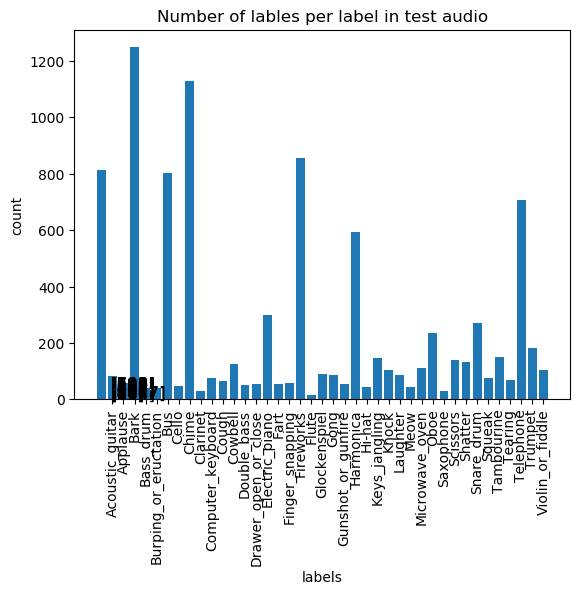

In [170]:

 
category_group = data.groupby(['label']).count()
value=[]
for i in category_group.values:
    value.append(i[0])


plt.bar(x=np.arange(0,41),height=value)
for i, v in enumerate(category_group.values):
    plt.text(0.8,i,v,color='k',fontsize=12)
#Give it a title
plt.title("Number of lables per label in test audio")

#Give the x axis some labels across the tick marks.
#Argument one is the position for each label
#Argument two is the label values and the final one is to rotate our labels
plt.xticks(np.arange(1,41), category_group.index, rotation=90)

#Give the x and y axes a title
plt.xlabel("labels")
plt.ylabel("count")

#Finally, show me our new plot
plt.show()

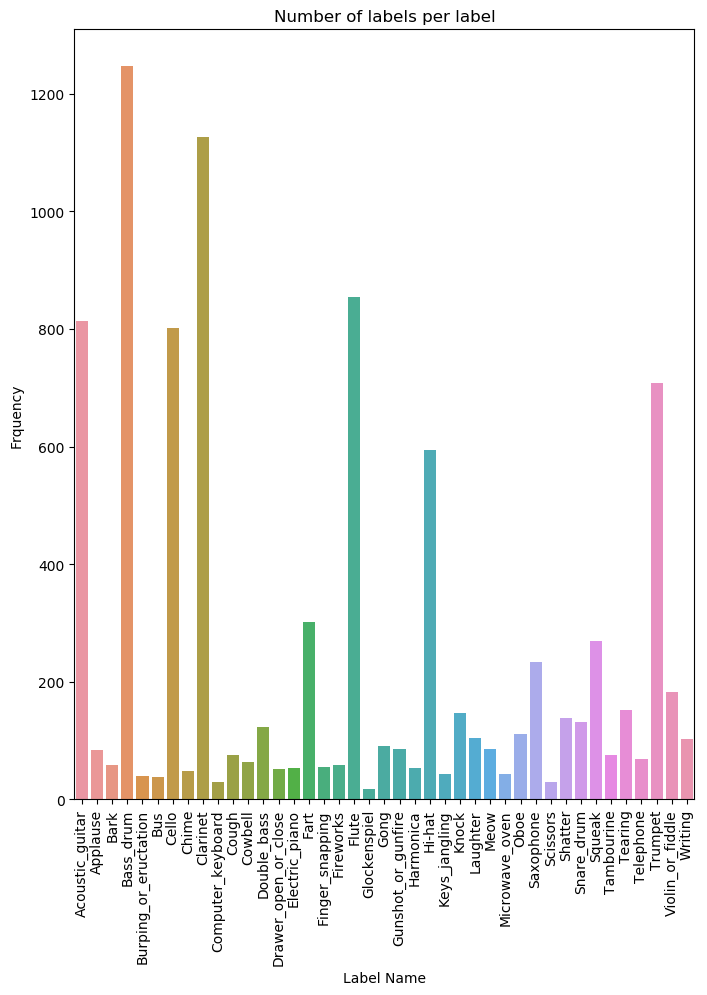

In [199]:
plt.figure(figsize=(8,10))

sns.barplot(category_group.index,value)

plt.xticks(rotation=90)
plt.xlabel('Label Name')
plt.ylabel('Frquency')
plt.title("Number of labels per label")
plt.show()